In [15]:
import casatasks

ModuleNotFoundError: No module named '_synthesismaskhandler'

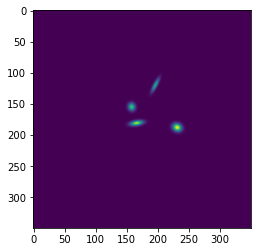

In [14]:
amps = np.linspace(1.,5.,num=100).astype(np.float)
xyposs = np.arange(100,250).astype(np.float)
fwhms = np.linspace(2.,8.,num=100).astype(np.float)
angles = np.linspace(0,90,num=900).astype(np.float)
line_centres = np.linspace(20, 100, num=100).astype(np.float)
line_fwhms = np.linspace(3, 10, num=100).astype(np.float)
idxs = np.indices([350, 350])
z_idxs = np.linspace(0, 128, 128)
i = 0
cube, params = utils.make_cube(i, amps, xyposs, fwhms, angles, line_centres, line_fwhms, idxs, z_idxs)
plt.imshow(np.sum(cube, axis=0))